In [68]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
from glob import glob
import copy

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

In [69]:
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Create Train and Val Sets

In [70]:
df = pd.read_csv('../data/HAM10000_balanced.csv')
df.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,binary_target,cat_target
0,6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis-like lesions,-1,Non-Melanoma
1,11,HAM_0004234,ISIC_0029396,bkl,histo,85.0,female,chest,Benign keratosis-like lesions,-1,Non-Melanoma
2,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,-1,Non-Melanoma
3,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,-1,Non-Melanoma
4,16,HAM_0001601,ISIC_0025915,bkl,histo,75.0,male,upper extremity,Benign keratosis-like lesions,-1,Non-Melanoma


In [71]:
imageid_path = {os.path.splitext(os.path.basename(x))[0]: x 
                for x in glob(os.path.join('..\\data\\HAM10000', '*.jpg'))}

In [72]:
df['path'] = df['image_id'].map(imageid_path.get)

### Create a stratified val set

In [73]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['cat_target']

_, df_val = train_test_split(df, test_size=0.1, random_state=64, stratify=y)

df_val.shape

(223, 12)

In [74]:
df_val['cat_target'].value_counts()

Melanoma        112
Non-Melanoma    111
Name: cat_target, dtype: int64

### Create a train set that excludes images that are in the val set

In [75]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df['train_or_val'] = df['image_id']
# apply the function to this new column
df['train_or_val'] = df['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df[df['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

1969
223


In [76]:
df_train['cat_target'].value_counts()

Melanoma        1001
Non-Melanoma     968
Name: cat_target, dtype: int64

In [77]:
df_val['cat_target'].value_counts()

Melanoma        112
Non-Melanoma    111
Name: cat_target, dtype: int64

In [79]:
df_train[df_train['cat_target']=='Melanoma']['path']

329     ..\data\HAM10000\ISIC_0025964.jpg
330     ..\data\HAM10000\ISIC_0030623.jpg
331     ..\data\HAM10000\ISIC_0027190.jpg
332     ..\data\HAM10000\ISIC_0031023.jpg
333     ..\data\HAM10000\ISIC_0028086.jpg
                      ...                
1437    ..\data\HAM10000\ISIC_0025611.jpg
1919    ..\data\HAM10000\ISIC_0032985.jpg
1974    ..\data\HAM10000\ISIC_0032936.jpg
1975    ..\data\HAM10000\ISIC_0033232.jpg
2225    ..\data\HAM10000\ISIC_0032258.jpg
Name: path, Length: 1001, dtype: object

### Copy the train images  into aug_dir

In [87]:
class_list = ['Melanoma', 'Non-Melanoma']
for item in class_list:
    img_class = item
    df_item = df_train[df_train['cat_target']==item]
    
    datagen = ImageDataGenerator(
        rotation_range=180,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    batch_size = 50
    
    save_dir = '../data/aug_dir/' + item
    
    aug_datagen = datagen.flow_from_dataframe(
        df_item,
        x_col='path',
        y_col='binary_target',
        class_mode='raw',
        save_to_dir=save_dir,
        save_format='jpg',
        target_size=(224,224),
        batch_size=batch_size)
    
    num_aug_images_wanted = 5000
    num_files = len(df_item)
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))
    
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)

Found 1001 validated image filenames.
Found 968 validated image filenames.


### Visualize 50 augmented images

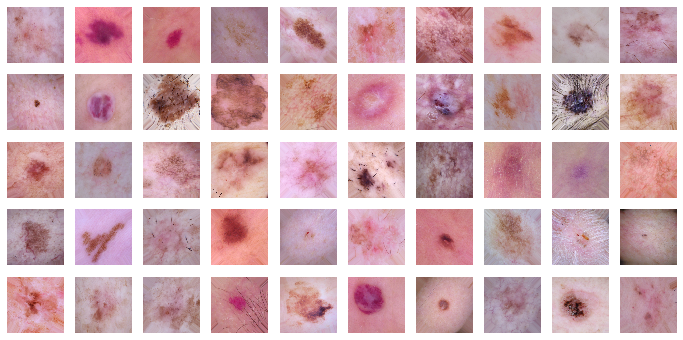

In [88]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

### Move train set into val_dir

In [89]:
class_list = ['Melanoma', 'Non-Melanoma']
for item in class_list:
    img_class = item
    df_item = df_val[df_val['cat_target']==item]
    
    datagen = ImageDataGenerator()

    batch_size = len(df_item)
    
    save_dir = '../data/val_dir/' + item
    
    aug_datagen = datagen.flow_from_dataframe(
        df_item,
        x_col='path',
        y_col='binary_target',
        class_mode='raw',
        save_to_dir=save_dir,
        save_format='jpg',
        target_size=(224,224),
        batch_size=batch_size)

    imgs, labels = next(aug_datagen)

Found 112 validated image filenames.
Found 111 validated image filenames.


In [22]:
# End of Data Preparation
### ===================================================================================== ###